# Введение в регрессионный анализ
## Семинар 5. Парные и множественные модели. Мера $R^2$

*Алла Тамбовцева*

### Контекст исследования

В файле `english.csv` сохранены результаты психолингвистического исследования, посвященного узнаваемости слов (*lexical decision & word naming*). В такого рода исследованиях участникам эксперимента предлагают определить, является ли слово, которое они видят на экране, реально существующим в языке или нет. Другими словами, настоящее это слово или что-то выдуманное, но созданное по правилам языка. Если участники узнают слово, они должны прочитать его вслух и нажать на специальную кнопку. Время, затраченное на узнавание слова фиксируется и измеряется в милисекундах: 
насколько быстро человек нажал на кнопку (реальное слово или нет, *lexical decision*), 
или прочитал слово (*word naming*).

### Переменные 

Некоторые из переменных (в файле `english.csv` отобраны только случаи с реально существующими словами, иначе грамматические характеристики ниже будут неприменимы):

* `AgeSubject`: молодой участник эксперимента или нет;
* `WordCategory`: часть речи (`N` – существительное, `V` – глагол);
* `RTlexdec`: время в милисекундах, затраченное на узнавание слова (с момента появления слова на экране до нажатия кнопки, реальное слово или нет);
* `RTnaming`: время в милисекундах, затраченное на называние слова (с момента появления слова на экране до произнесения его вслух);
* `WrittenFrequency`: мера того, насколько часто слово встречается в письменных текстах;
* `LengthInLetters`: длина слова в буквах;
* `FamilySize`: мера того, насколько богата морфологическая семья слова (как много однокоренных слов с разной частью речи);
* `NumberSimplexSynsets`: мера того, насколько у слова много синонимов.

### План нашего исследования

1. Сравнить среднее время в милисекундах, затраченное на узнавание слова (`RTlexdec`) молодыми участниками эксперимента и более старшими. Проверить значимость различий на 95%-ном уровне доверия с помощью подходящего статистического критерия.

2. Выбрать строки, соответствующие молодым участникам эксперимента. На этой подвыборке:

 * построить модель, которая объясняет, как время, затрачиваемое на узнавание слова, зависит от его встречаемости в письменных текстах; прокомментировать результаты и качество полученной модели;

 * построить модель, которая объясняет, как время, затрачиваемое на узнавание слова, зависит от его встречаемости в письменных текстах, его длины, размера морфологической семьи и количества синонимов; прокомментировать результаты и качество полученной модели.
 
3. Выбрать строки, соответствующие более старшим участникам эксперимента. На этой подвыборке построить те же модели, что и выше. Прокомментировать полученные результаты.

### Часть 1: знакомство с данными и сравнение групп

Импортируем необходимые инструменты для работы:

* библиотеку `pandas` для работы с данными;
* модуль `stats` из библиотеки `scipy` для реализации t-теста;
* функцию `ols` из библиотеки `statsmodels` для построения моделей.

In [2]:
import pandas as pd
from scipy import stats
from statsmodels.formula.api import ols

Загрузим данные:

In [3]:
df = pd.read_csv("english.csv")
df.head()

,AgeSubject,WordCategory,RTlexdec,RTnaming,WrittenFrequency,LengthInLetters,FamilySize,NumberSimplexSynsets
0,young,N,6.543754,6.145044,3.912023,3,1.386294,0.693147
1,young,N,6.397596,6.246882,4.521789,5,1.386294,1.098612
2,young,N,6.304942,6.143756,6.505784,6,1.609438,2.484907
3,young,N,6.424221,6.131878,5.017280,4,1.945910,1.098612
4,young,N,6.450597,6.198479,4.890349,4,2.197225,2.484907


Посмотрим, в каком формате представлен возраст участников эксперимента:

In [4]:
# одинаковое число в категориях young и old
# одинаковое число молодых и не очень

df["AgeSubject"].value_counts()

young    2284
old      2284
Name: AgeSubject, dtype: int64

Сгруппируем строки в таблице на основе возраста участников эксперимента (`AgeSubject`) и выведем описательные статистики для времени в милисекундах, затраченное на узнавание слова (`RTlexdec`) по группам:

In [5]:
df.groupby("AgeSubject")["RTlexdec"].describe()

,count,mean,std,min,25%,50%,75%,max
AgeSubject,,,,,,,,
old,2284.0,6.660958,0.115588,6.403193,6.574678,6.642135,6.728554,7.187808
young,2284.0,6.439237,0.106331,6.205325,6.359345,6.425606,6.510363,6.879150


Молодые участники, в целом, узнают слова быстрее, чем более старшие (среднее и медианное значения в этой группе ниже, то же можно сказать и про минимальное с максимальным). Однако разница в средних кажется небольшой – примерно 0.2. Изучим распределение времени узнавания слова по группам с помощью гистограмм: 

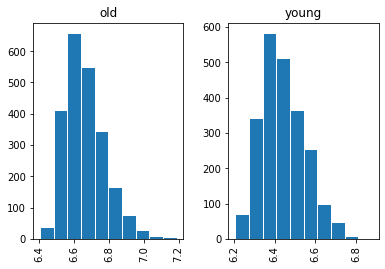

In [6]:
df.hist("RTlexdec", edgecolor = "white", by = "AgeSubject");

Распределение времени угадывания слова в двух группах похоже по форме, наблюдается небольшая скошенность вправо. Гистограммы позволяют более наглядно понять, что 0.2 мс в контексте изучаемых данных – не так уж и мало, в интервале длины 0.2 может находиться достаточно много наблюдений (если не рассматривать более редкие значения в хвостах распределения).

Проверим формально, можно ли считать среднее время узнавания слова молодыми и старшими участниками одинаковым. Вспомним про критерий Стьюдента для двух независимых выборок! Для его применения необходимо поделить данные на группы, то есть отфильтровать строки с молодыми и более старшими участниками в отдельные датафреймы:

In [7]:
young = df[df["AgeSubject"] == "young"]
old = df[df["AgeSubject"] == "old"]

Реализуем критерий Стьюдента – проверяем гипотезу о том, что среднее время угадывания слов молодыми и старшими участниками равно, $H_0: E(x) = E(y)$.

In [8]:
stats.ttest_ind(young["RTlexdec"], old["RTlexdec"])

Ttest_indResult(statistic=-67.46820211231773, pvalue=0.0)

Получили очень большое по модулю наблюдаемое значение t-статистики и p-value равное 0. На уровне доверия 95% гипотезу следует отвергнуть, средние не равны, молодые участники, в среднем, узнают слова быстрее.

### Часть 2: регрессионные модели

Построим модель парной линейной регрессии, которая которая объясняет, как время, затрачиваемое на узнавание слова (`RTlexdec`), зависит от его встречаемости в письменных текстах (`WrittenFrequency`):

In [9]:
model01 = ols("RTlexdec ~ WrittenFrequency", data = young).fit()
print(model01.summary())

                            OLS Regression Results                            
Dep. Variable:               RTlexdec   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     1612.
Date:                Mon, 14 Oct 2024   Prob (F-statistic):          3.88e-267
Time:                        05:03:07   Log-Likelihood:                 2488.9
No. Observations:                2284   AIC:                            -4974.
Df Residuals:                    2282   BIC:                            -4962.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            6.6256      0.005  

**Интерпретация.**

* Уравнение: $\widehat{\text{RTlexdec_}i} = 6.63 - 0.04 \times \text{WrittenFrequency}_i$. 
* При увеличении показателя встречаемости слова в письменных текстах на единицу, время узнавания слова, в среднем, уменьшается на 0.04 мс. Логичная обратная связь между показателями, чем чаще слово можно встретить в текстах, тем быстрее его узнают, видя на экране. Коэффициент значимо отличен от нуля, так как гипотеза $H_0: b_1 = 0$ отвергается на любом уровне значимости (наблюдаемое значение статистики `t=-40.152`, p-value равно 0), то есть эффект `WrittenFrequency` действительно есть, значение оценки коэффициента (-0.04) нельзя объяснить чистой случайностью.
* Согласно модели, среднее время узнавания слова, которое не встречается в письменных текстах (`WrittenFrequency` равно 0), составляет 6.63 мс. Теоретически это могло бы быть выдуманное слово, но в нашем случае в данных только реально существующие. Однако константа нас интересует редко, недостаточно реалистичная интерпретация не должна смущать.
* $R^2$ модели равен 0.414, модель объясняет примерно 41% дисперсии зависимой переменной. То, насколько разнообразны значения времени узнавания слова в эксперименте, можно на 41% объяснить разнообразием значений меры встречамости слова в письменных текстах.
* Так как модель парная, $R^2$ здесь – это коэффициент Пирсона, возведённый в квадрат. Модуль коэффициента Пирсона равен квадратному корню из 0.414, примерно 0.64. Однако сам коэффициент Пирсона равен (-0.64), так как по оценке коэффициента при `WrittenFrequency` видно, что связь между показателями обратная.

Построим модель, которая объясняет, как время, затрачиваемое на узнавание слова (`RTlexdec`), зависит от его встречаемости в письменных текстах (`WrittenFrequency`), его длины (`LengthInLetters`), размера морфологической семьи (`FamilySize`) и количества синонимов (`NumberSimplexSynsets`).

In [10]:
model02 = ols("RTlexdec ~ WrittenFrequency + LengthInLetters + FamilySize + NumberSimplexSynsets", 
              data = young).fit()
print(model02.summary())

                            OLS Regression Results                            
Dep. Variable:               RTlexdec   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     433.9
Date:                Mon, 14 Oct 2024   Prob (F-statistic):          3.06e-278
Time:                        05:03:09   Log-Likelihood:                 2525.2
No. Observations:                2284   AIC:                            -5040.
Df Residuals:                    2279   BIC:                            -5012.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                6.6297 

**Интерпретация.**

* Уравнение: $$\widehat{\text{RTlexdec_}i} = 6.63 - 0.03 \times \text{WrittenFrequency}_i + 0.002 \times \text{LengthInLetters}_i -0.02 \times \text{FamilySize}_i - 0.01 \times \text{NumberSimplexSynsets}_i.$$
* Согласно модели, среднее время узнавания слова, которое не встречается в письменных текстах (`WrittenFrequency` равно 0), имеет длину 0 (`LengthInLetter` равно 0), не имеет однокоренных слов и синонимов (`FamilySize` и `NumberSimplexSynsets` равны 0), составляет 6.63 мс. Тоже звучит не очень реалистично, но константу из модели мы не выкидываем.
* **При прочих равных условиях,** при увеличении показателя встречаемости слова в письменных текстах на единицу, время узнавания слова, в среднем, уменьшается на 0.03 мс. При прочих равных условиях в данном случае – если мы сравниваем слова одинаковой длины, с одинаковым числом однокоренных слов и синонимов, то есть слова, которые отличаются только по показателю `WrittenFrequency`.
* **При прочих равных условиях,** при увеличении длины слова на одну букву, время узнавания слова, в среднем, увеличивается на 0.002 мс. Однако этот коэффициент не имеет смысла интерпретировать, p-value равно 0.245, а значит, на любом уровне значимости гипотеза о равенстве коэффициента при `LengthInLetter` нулю не отвергается. Длина слова не оказывает особого эффекта на его узнаваемость (точнее, на время, затрачиваемое на узнавание).
* **При прочих равных условиях,** при увеличении размера морфологической семьи на единицу, время узнавания слова, в среднем, уменьшается на 0.02 мс. Эффект статистически значимый, все вполне логично, чем больше однокоренных слов у слова, тем чаще оно возникает в разных контекстах, а значит, тем быстрее оно узнается.
* **При прочих равных условиях,** при увеличении количества синонимов (количества семейств синонимов) на единицу, время узнавания слова, в среднем, уменьшается на 0.01 мс. Эффект статистически значимый, и обратная связь здесь тоже ожидаема.
* $R^2$ модели равен 0.432, модель объясняет примерно 43% дисперсии зависимой переменной. То, насколько разнообразны значения времени узнавания слова в эксперименте, можно на 43% объяснить разнообразием значений перечисленных в модели факторов.

P.S. Пункт 3 плана работы в начале файла можно считать необязательным домашним заданием :) Кто хочет побольше поизучать эффект построения моделей на разных подвыборках и понять, почему деление на группы по возрасту здесь важно, может дополнительно построить регрессионные модели на основе всех наблюдений в `df` и посмотреть, что произойдёт в таком случае с коэффициентами и $R^2$.